In [1]:
import pandas as pd
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [47]:
# 1. Загружаем таблицу с путями и метками
df = pd.read_csv("C:/Users/Leopard/Desktop/Jupyter_Python_ML/Univer/Final_AI_model/dataset_fianl/image_labels.csv")

In [49]:
base_dir = "C:/Users/Leopard/Desktop/Jupyter_Python_ML/Univer/Final_AI_model/Dataset_dish"  

In [51]:
# Удаляем строки, где cal_label отсутствует
df = df.dropna(subset=['cal_label'])

In [53]:
# 2. Разбиваем на train и validation
train_df, val_df = train_test_split(df, test_size=0.15,
                                    stratify=df['cal_label'],
                                    random_state=42)

In [55]:
# Заменяем слеши в путях (универсально для всех строк)
train_df['image_path'] = train_df['image_path'].apply(lambda x: x.replace('\\', '/'))
val_df['image_path'] = val_df['image_path'].apply(lambda x: x.replace('\\', '/'))

In [57]:
print(train_df['image_path'].iloc[0])
print(os.path.join(base_dir, train_df['image_path'].iloc[0]))
# Это должен быть реальный .jpg файл

C:/Users/Leopard/Desktop/Jupyter_Python_ML/Univer/Final_AI_model/Dataset_dish/dish_1566849923/frames_sampled30/camera_A_frame_001.jpeg
C:/Users/Leopard/Desktop/Jupyter_Python_ML/Univer/Final_AI_model/Dataset_dish/dish_1566849923/frames_sampled30/camera_A_frame_001.jpeg


In [59]:
# 3. Создаём генератор с аугментацией для train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1,
    horizontal_flip=True
)

In [61]:
# Без аугментации для валидации, только рескейл
val_datagen = ImageDataGenerator(rescale=1./255)

In [63]:
# 4. Генераторы
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=base_dir,
    x_col='image_path',
    y_col='cal_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=base_dir,
    x_col='image_path',
    y_col='cal_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 3610 validated image filenames belonging to 3 classes.
Found 638 validated image filenames belonging to 3 classes.


In [65]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [67]:
# 1. Базовая модель без классификатора
base_model = EfficientNetB0(weights='imagenet', include_top=False,
                            input_shape=(224, 224, 3))
base_model.trainable = False  # замораживаем предобученные веса

In [69]:
# 2. Собираем модель
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    run_eagerly=True
)

In [71]:
# 3. Callbacks
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


In [75]:
# Считаем веса
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y = train_generator.classes
classes = np.unique(y)

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y
)

class_weights = dict(zip(classes, weights))

In [91]:
# 4. Обучение
model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[es, mc],
    class_weight=class_weights
)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - accuracy: 0.4226 - loss: 1.1160 - val_accuracy: 0.0423 - val_loss: 1.1208
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - accuracy: 0.3199 - loss: 1.0725 - val_accuracy: 0.7680 - val_loss: 1.0852
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.3581 - loss: 1.1055 - val_accuracy: 0.7680 - val_loss: 1.0879
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.3499 - loss: 1.0875 - val_accuracy: 0.7680 - val_loss: 1.0732
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - accuracy: 0.4045 - loss: 1.0605 - val_accuracy: 0.0423 - val_loss: 1.1598
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - accuracy: 0.2508 - loss: 1.1513 - val_accuracy: 0.1897 - val_loss: 1.0892
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.3303 - loss: 1.0929 - val_accuracy: 0.0423 - val_loss: 1.1054
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - accuracy: 0.3312 - loss: 1.0780 - val_accu

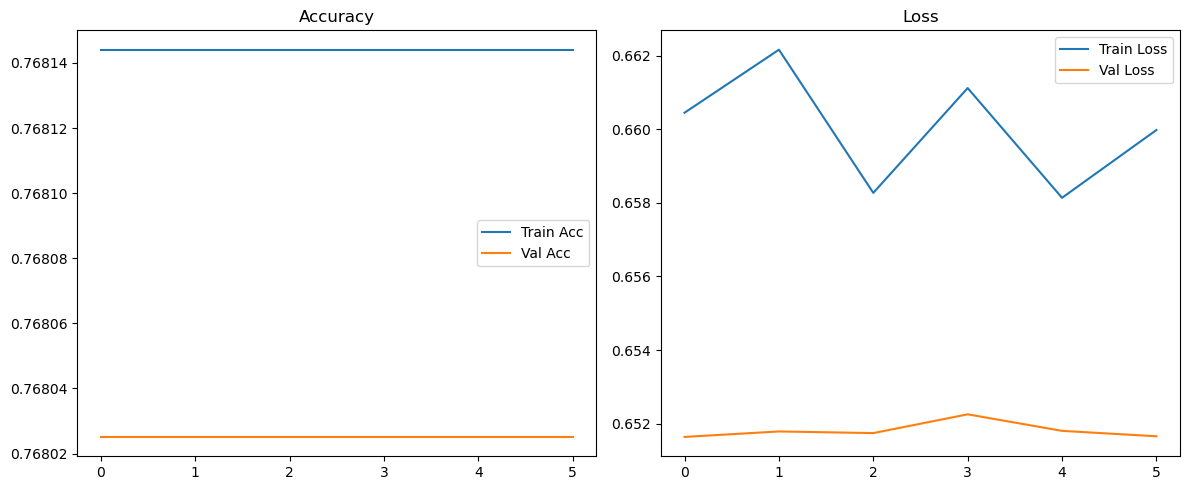

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [95]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Предсказания
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 901ms/step


In [83]:
# Метки классов
class_labels = list(val_generator.class_indices.keys())

In [85]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[  0  27   0]
 [  0 490   0]
 [  0 120   1]]


In [87]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        27
         low       0.77      1.00      0.87       490
      medium       1.00      0.01      0.02       121

    accuracy                           0.77       638
   macro avg       0.59      0.34      0.30       638
weighted avg       0.78      0.77      0.67       638



C:\Users\Leopard\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Leopard\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Leopard\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


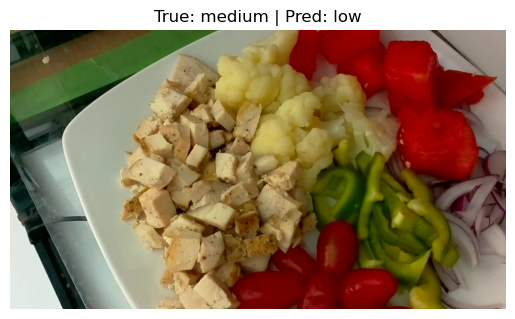

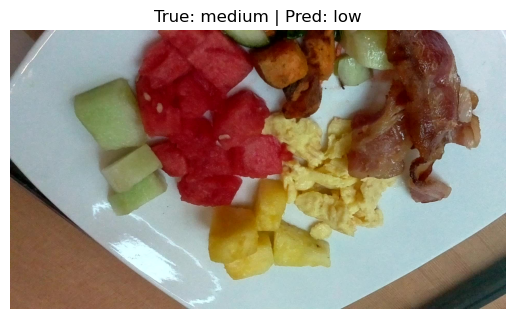

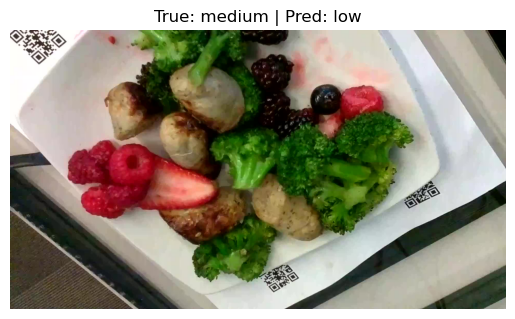

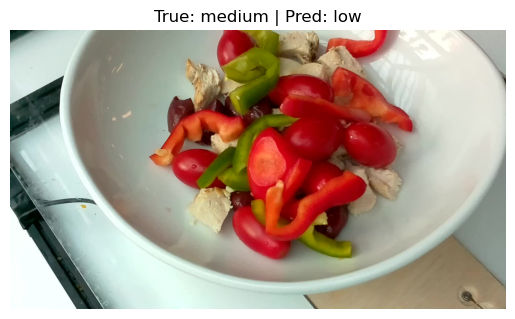

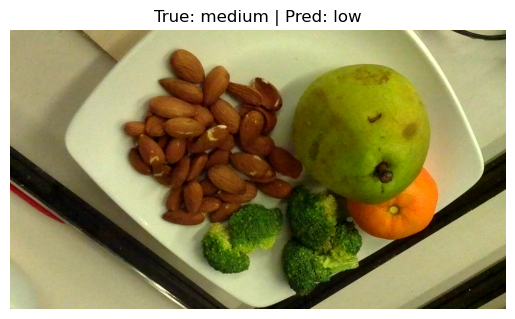

In [89]:
import matplotlib.pyplot as plt

# Получим пути и названия классов
file_paths = val_generator.filepaths
true_labels = y_true
pred_labels = y_pred

# Показать 5 неверных
wrong_idx = np.where(pred_labels != true_labels)[0]

for i in range(5):
    idx = wrong_idx[i]
    img = plt.imread(file_paths[idx])
    plt.imshow(img)
    plt.title(f"True: {class_labels[true_labels[idx]]} | Pred: {class_labels[pred_labels[idx]]}")
    plt.axis('off')
    plt.show()